In [1]:
import numpy as np
import pandas as pd

import QuantLib as ql
import matplotlib.pyplot as plt
from scipy.stats import norm

In [2]:
N = 10000    # Number of parameters

# Market Parameters
K = np.random.uniform(90, 110, N)
t = np.random.uniform(0.1, 1, N)  # Assuming t is in years, so 0.01 to 1 year
r = np.random.uniform(0.01, 0.06, N)
v = np.random.uniform(0.2, 0.5, N)
q = np.random.uniform(0.01, 0.03, N)
df = pd.DataFrame({'K': K,
                   't': t,
                   'r': r,
                   'v': v,
                   'q': q})
df

,K,t,r,v,q
0,102.459859,0.481071,0.013187,0.350950,0.010246
1,101.111542,0.289394,0.011582,0.431603,0.016907
2,101.714919,0.303954,0.047454,0.354753,0.012855
3,90.024392,0.706426,0.059557,0.419759,0.025041
4,96.404339,0.402632,0.044005,0.336199,0.019747
...,...,...,...,...,...
9995,107.150755,0.964746,0.021654,0.408694,0.026390
9996,106.578278,0.430273,0.022814,0.216600,0.014171
9997,93.956203,0.334388,0.022267,0.210059,0.021015
9998,100.358539,0.127487,0.035233,0.346749,0.019908


In [3]:
def european_option_price_binomial(S, K, T, r, q, sigma, option_type="call", n_steps=100):
  """
  Compute European option price using QuantLib's binomial model.

  Parameters:
  - S: Stock price
  - K: Strike price
  - T: Time to maturity
  - r: Risk-free rate
  - q: Dividend yield
  - sigma: Volatility
  - option_type: "call" or "put"

  Returns:
  - Option price
  """

  # Define the option's data
  day_count = ql.Actual365Fixed()
  today = ql.Date.todaysDate()
  expiry_date = today + ql.Period(f"{int(T*365)}d")

  ql.Settings.instance().evaluationDate = today

  # Convert to QuantLib format

  spot = ql.SimpleQuote(S)  # there are also CompositeQuote: market element whose value depends on two other market element, etc

  rate = ql.SimpleQuote(r) # DerivedQuote:	market quote whose value depends on another quote
  dividend = ql.SimpleQuote(q)
  volatility = ql.SimpleQuote(sigma)
  # Interest-rate term structure
  flat_ts = ql.YieldTermStructureHandle(ql.FlatForward(today, ql.QuoteHandle(rate), day_count))
  dividend_yield = ql.YieldTermStructureHandle(ql.FlatForward(today, ql.QuoteHandle(dividend), day_count))
  # Volatility term structure
  flat_vol = ql.BlackVolTermStructureHandle(ql.BlackConstantVol(today, ql.TARGET(), ql.QuoteHandle(volatility), day_count))

  # Set up the option
  exercise = ql.EuropeanExercise(expiry_date)
  payoff = ql.PlainVanillaPayoff(ql.Option.Call if option_type == "call" else ql.Option.Put, K)

  european_option = ql.VanillaOption(payoff, exercise)

  # Pricing engine
  bsm_process = ql.BlackScholesMertonProcess(ql.QuoteHandle(spot), dividend_yield, flat_ts, flat_vol)
  binomial_engine = ql.BinomialVanillaEngine(bsm_process, "crr", n_steps)
  european_option.setPricingEngine(binomial_engine)

  return european_option.NPV()

def american_option_price_binomial(S, K, T, r, q, sigma, option_type="call", n_steps=100):
  """
  Compute American option price using QuantLib's binomial model.

  Parameters:
  - S: Stock price
  - K: Strike price
  - T: Time to maturity
  - r: Risk-free rate
  - q: Dividend yield
  - sigma: Volatility
  - option_type: "call" or "put"

  Returns:
  - Option price
  """

  # Define the option's data
  day_count = ql.Actual365Fixed()
  today = ql.Date.todaysDate()
  expiry_date = today + ql.Period(f"{int(T*365)}d")

  ql.Settings.instance().evaluationDate = today

  # Convert to QuantLib format

  spot = ql.SimpleQuote(S)  # there are also CompositeQuote: market element whose value depends on two other market element, etc

  rate = ql.SimpleQuote(r) # DerivedQuote:	market quote whose value depends on another quote
  dividend = ql.SimpleQuote(q)
  volatility = ql.SimpleQuote(sigma)
  # Interest-rate term structure
  flat_ts = ql.YieldTermStructureHandle(ql.FlatForward(today, ql.QuoteHandle(rate), day_count))
  dividend_yield = ql.YieldTermStructureHandle(ql.FlatForward(today, ql.QuoteHandle(dividend), day_count))
  # Volatility term structure
  flat_vol = ql.BlackVolTermStructureHandle(ql.BlackConstantVol(today, 
                                                                ql.TARGET(), 
                                                                ql.QuoteHandle(volatility), 
                                                                day_count)
  )

  # Set up the option
  exercise = ql.AmericanExercise(today, expiry_date)#change exercise type to american
  payoff = ql.PlainVanillaPayoff(ql.Option.Call if option_type == "call" else ql.Option.Put, K)

  american_option = ql.VanillaOption(payoff, exercise)

  # Pricing engine
  bsm_process = ql.BlackScholesMertonProcess(ql.QuoteHandle(spot), dividend_yield, flat_ts, flat_vol)
  binomial_engine = ql.BinomialVanillaEngine(bsm_process, "crr", n_steps)
  american_option.setPricingEngine(binomial_engine)

  return american_option.NPV()


In [4]:
%%time
df['American_binomial_value'] = df.apply(lambda x: american_option_price_binomial(100, x['K'], x['t'], x['r'], x['q'], x['v'], option_type='call', n_steps=100), axis=1)

CPU times: total: 438 ms
Wall time: 1.28 s


In [5]:
%%time
df['European_binomial_value'] = df.apply(lambda x: european_option_price_binomial(100, x['K'], x['t'], x['r'], x['q'], x['v'], option_type='call', n_steps=100), axis=1)
df

CPU times: total: 344 ms
Wall time: 836 ms


,K,t,r,v,q,American_binomial_value,European_binomial_value
0,102.459859,0.481071,0.013187,0.350950,0.010246,8.554424,8.649516
1,101.111542,0.289394,0.011582,0.431603,0.016907,8.634614,8.621465
2,101.714919,0.303954,0.047454,0.354753,0.012855,7.446823,7.446823
3,90.024392,0.706426,0.059557,0.419759,0.025041,19.744001,19.743135
4,96.404339,0.402632,0.044005,0.336199,0.019747,10.647923,10.647923
...,...,...,...,...,...,...,...
9995,107.150755,0.964746,0.021654,0.408694,0.026390,12.716446,12.636556
9996,106.578278,0.430273,0.022814,0.216600,0.014171,3.243136,3.243135
9997,93.956203,0.334388,0.022267,0.210059,0.021015,8.308290,8.299084
9998,100.358539,0.127487,0.035233,0.346749,0.019908,4.817589,4.817589


In [6]:
df[df['American_binomial_value'] - df['European_binomial_value'] < 0]

,K,t,r,v,q,American_binomial_value,European_binomial_value
0,102.459859,0.481071,0.013187,0.350950,0.010246,8.554424,8.649516
7,107.631333,0.818622,0.052846,0.454903,0.010574,14.506227,14.552857
16,96.078629,0.117110,0.051674,0.359714,0.016601,7.181261,7.215973
30,98.583687,0.419118,0.021010,0.313507,0.019713,8.653160,8.698785
54,91.381545,0.441197,0.036026,0.231682,0.020983,11.454313,11.464616
...,...,...,...,...,...,...,...
9899,105.031673,0.821383,0.020045,0.325301,0.010407,9.839579,9.880877
9920,93.866348,0.053148,0.049854,0.314308,0.020630,6.947885,6.963946
9926,102.159667,0.104520,0.034785,0.393198,0.029927,4.098231,4.114028
9944,108.918300,0.469272,0.021636,0.481231,0.011729,9.717495,9.795111


In [7]:
df[df['American_binomial_value'] - df['European_binomial_value'] > 0]

,K,t,r,v,q,American_binomial_value,European_binomial_value
1,101.111542,0.289394,0.011582,0.431603,0.016907,8.634614,8.621465
3,90.024392,0.706426,0.059557,0.419759,0.025041,19.744001,19.743135
4,96.404339,0.402632,0.044005,0.336199,0.019747,10.647923,10.647923
5,101.903902,0.621128,0.049858,0.307193,0.014260,9.699337,9.699337
6,99.158061,0.019838,0.025393,0.467077,0.029556,3.011881,3.011243
...,...,...,...,...,...,...,...
9993,96.629655,0.252426,0.039172,0.222081,0.028959,6.374073,6.374038
9995,107.150755,0.964746,0.021654,0.408694,0.026390,12.716446,12.636556
9996,106.578278,0.430273,0.022814,0.216600,0.014171,3.243136,3.243135
9997,93.956203,0.334388,0.022267,0.210059,0.021015,8.308290,8.299084


In [8]:
#only 5.89% of all the random cases that have American option values below its European values 
len(df[df['American_binomial_value'] - df['European_binomial_value'] < 0])/len(df)

0.0589

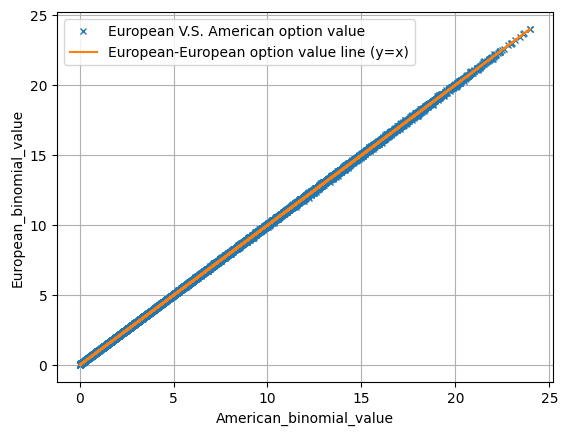

In [9]:
plt.plot(df['American_binomial_value'], df['European_binomial_value'], marker='x', ms=4, linestyle='none', label = 'European V.S. American option value')
plt.plot(df['European_binomial_value'], df['European_binomial_value'], marker='x', ms=0.5, label='European-European option value line (y=x)')
plt.xlabel('American_binomial_value')
plt.ylabel('European_binomial_value')
plt.grid()
plt.legend()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


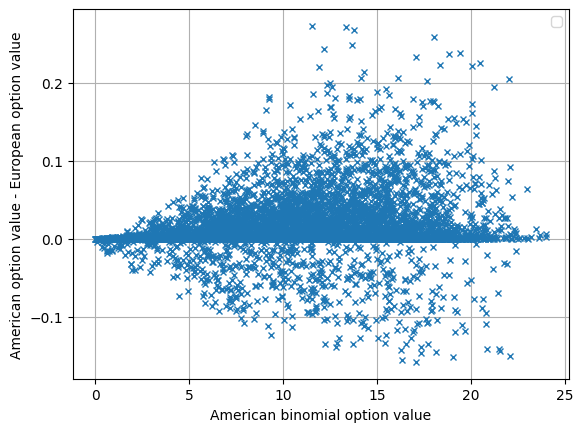

In [10]:
plt.plot(df['American_binomial_value'] , df['American_binomial_value'] - df['European_binomial_value'], marker='x', ms=4, linestyle='none')
plt.xlabel('American binomial option value')
plt.ylabel('American option value - European option value')
plt.grid()
plt.legend()
plt.show()

# Discussion
## Question: What do they tell you, if anything?
- I think it is quite rare that value of a european option is greather than that of the american option given the same set of parameters. There could be several reason why american option values are below the european option value. From observation, this could be due to estimation error especially when the estimated value of both options are close to each other. As we can see it the play around session below, I showed an example when the risk free rate is quite high (around 5%) the true values of both options become close to each other, and the fluctuation of the estimated option values causes the differences between american and european option values to be negative.
## Question: Is the European call option price a good proxy for an American call option price?
- I think we may use the European call option price a proxy for an American call option price in the case that the option values are really high. As we can clearly see in 2 plots above and in the play around session below, the most of differences between those 2 values tend to be in between -0.1 to 0.1. So, if the error is roughly fixed, the error tends to be relatively low when the values of the option is high. However, it totally depends on how much error we are willing to torlerate.

# Verification of the code (play around)

In [11]:
steps = range(2, 300, 1)
# maturity_date = ql.Date(15, 1, 2016)
spot_price = 100#127.62
strike_price = 97.270943#130
volatility = 0.211851 # the historical vols for a year
dividend_rate =  0.020096	
# option_type = ql.Option.Call
remaining_t = 0.232384
risk_free_rate = 0.01
eu_prices = [european_option_price_binomial(spot_price, strike_price, remaining_t, risk_free_rate, dividend_rate, volatility, option_type='call', n_steps=step) for step in steps]
am_prices = [american_option_price_binomial(spot_price, strike_price, remaining_t, risk_free_rate, dividend_rate, volatility, option_type='call', n_steps=step) for step in steps]

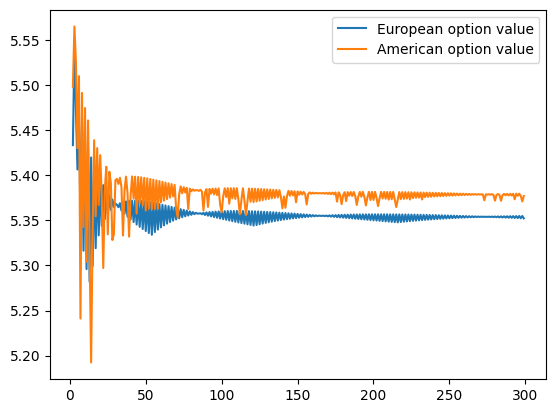

In [12]:
plt.plot(steps,eu_prices, label = 'European option value')
plt.plot(steps,am_prices, label = 'American option value')
plt.legend()
plt.show()

# Case when risk free rate is high while other parameters remain.

In [13]:
steps = range(2, 300, 1)
# maturity_date = ql.Date(15, 1, 2016)
spot_price = 100#127.62
strike_price = 97.270943#130
volatility = 0.211851 # the historical vols for a year
dividend_rate =  0.020096	
# option_type = ql.Option.Call
remaining_t = 0.232384
risk_free_rate = 0.05
eu_prices = [european_option_price_binomial(spot_price, strike_price, remaining_t, risk_free_rate, dividend_rate, volatility, option_type='call', n_steps=step) for step in steps]
am_prices = [american_option_price_binomial(spot_price, strike_price, remaining_t, risk_free_rate, dividend_rate, volatility, option_type='call', n_steps=step) for step in steps]

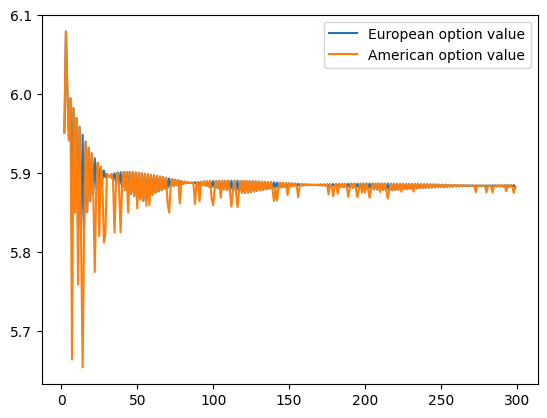

In [14]:
plt.plot(steps,eu_prices, label = 'European option value')
plt.plot(steps,am_prices, label = 'American option value')
plt.legend()
plt.show()